## Assignment 5 - CNNs on real cultural data

__Description:__ Multi-class classification of impressionist painters

__Data:__ https://www.kaggle.com/delayedkarma/impressionist-classifier-data

__Task:__ Using this data, you should build a deep learning model using convolutional neural networks which classify paintings by their artists. Why might we want to do this? Well, consider the scenario where we have found a new, never-before-seen painting which is claimed to be the artist Renoir. An accurate predictive model could be useful here for art historians and archivists!
- For this assignment, you can use the CNN code we went over in class, such as the ShallowNet architecture or LeNet. You are also welcome to build your own model, if you dare - I recommend against doing this.
- Perhaps the most challenging aspect of this assignment will be to get all of the images into format that can be fed into the CNN model. All of the images are of different shapes and sizes, so the first task will be to resize the images to have them be a uniform (smaller) shape.
- You'll also need to think about how to get the images into an array for the model and how to extract 'labels' from filenames for use in the classification report

__Tips__
- You should save visualisations showing loss/accuracy of the model during training; you should also a save the output from the classification report.
- I suggest working in groups for this assignment. The data is quite large and will take some time to move over to worker02. Similarly training the models will be time consuming, so it is preferably to have fewer models on the go.
- You might want to consider a division of labour in your group. One person working on resizing images, one working on extracting labels, one developing the model, etc.
- For reshaping images, I suggest checking out cv.resize() with the INTER_AREA method
- tf.keras has a useful tool for creating an an array from image which might be useful, called img_to_array()

__General instructions__
- Save your script as cnn-artists.py
- If you have external dependencies, you must include a requirements.txt
- You can either upload the script here or push to GitHub and include a link - or both!
- Your code should be clearly documented in a way that allows others to easily follow along
- Similarly, remember to use descriptive variable names! A name like X_train is (just) more readable than x1.
- The filenames of the saved images should clearly relate to the original image

__Libraries__

In [142]:
# data tools
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
from tqdm import tqdm

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

import glob

__Plot function__

In [143]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

__Estimating the optimal dimensions__

In [144]:
# Train data
heights_train = []
widths_train = []

train_dir = os.path.join("..", "data", "subset_impressionist_classifier_data", "training", "training")
label_names = os.listdir(train_dir)

for name in label_names:
    images = glob.glob(os.path.join(train_dir, name, "*.jpg"))
    
    for image in images:
        # Load image
        loaded_img = cv2.imread(image)
        # Dimensions
        height, width, _ = loaded_img.shape
        # Append
        heights_train.append(height)
        widths_train.append(width)

In [145]:
# Test data
heights_test = []
widths_test = []

test_dir = os.path.join("..", "data", "subset_impressionist_classifier_data", "validation", "validation")

for name in label_names:
    images = glob.glob(os.path.join(test_dir, name, "*.jpg"))
    
    for image in images:
        # Load image
        loaded_img = cv2.imread(image)
        # Dimensions
        height, width, _ = loaded_img.shape
        # Append
        heights_test.append(height)
        widths_test.append(width)

In [146]:
# Minimum height and width
min_height = min(widths_train + widths_test + heights_train + heights_test)
min_width = min(widths_train + widths_test + heights_train + heights_test)

In [147]:
print(min_height)
print(min_width)

336
336


__Create TrainX and TrainY__

In [148]:
trainX = np.empty((0,min_height,min_width,3))
trainY = []

for name in label_names:
    images = glob.glob(os.path.join(train_dir, name, "*.jpg"))
    
    for image in tqdm(images):
        # Load image
        loaded_img = cv2.imread(image)
        # Resize image
        resized_img = cv2.resize(loaded_img, (min_width, min_height), interpolation = cv2.INTER_AREA)
        # Create array
        image_array = np.array([np.array(resized_img)])
        # Append
        trainX = np.vstack((trainX, image_array))
        trainY.append(name)

100%|██████████| 10/10 [00:00<00:00, 14.35it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


__Normalize__

In [149]:
trainX = trainX.astype("float") / 255.

__Binarize__

In [150]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)

__Create TestX and TestY__

In [151]:
testX = np.empty((0,min_height,min_width,3))
testY = []

for name in label_names:
    images = glob.glob(os.path.join(test_dir, name, "*.jpg"))
    
    for image in tqdm(images):
        # Load image
        loaded_img = cv2.imread(image)
        # Resize image
        resized_img = cv2.resize(loaded_img, (min_width, min_height), interpolation = cv2.INTER_AREA)
        # Create array
        image_array = np.array([np.array(resized_img)])
        # Append
        testX = np.vstack((testX, image_array))
        testY.append(name)

100%|██████████| 10/10 [00:00<00:00, 14.13it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


__Normalize__

In [152]:
testX = testX.astype("float") / 255.

__Binarize__

In [153]:
lb = LabelBinarizer()
testY = lb.fit_transform(testY)

__Define LeNet Model__

In [154]:
# Define model
model = Sequential()

# Convolutional layer 
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape=(min_height, min_width, 3)))

# Activation function
model.add(Activation("relu"))

# Maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# Second convolutional layer 
model.add(Conv2D(50, (5, 5), 
                 padding="same"))

# Activation function
model.add(Activation("relu"))

# Maxpooling layer
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# FC => RELU
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(10))
model.add(Activation("softmax"))

__Compile model__

In [155]:
# Define optimizer 
opt = SGD(lr=0.01)

# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [156]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 336, 336, 32)      896       
_________________________________________________________________
activation_24 (Activation)   (None, 336, 336, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 168, 168, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 168, 168, 50)      40050     
_________________________________________________________________
activation_25 (Activation)   (None, 168, 168, 50)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 84, 84, 50)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 352800)           

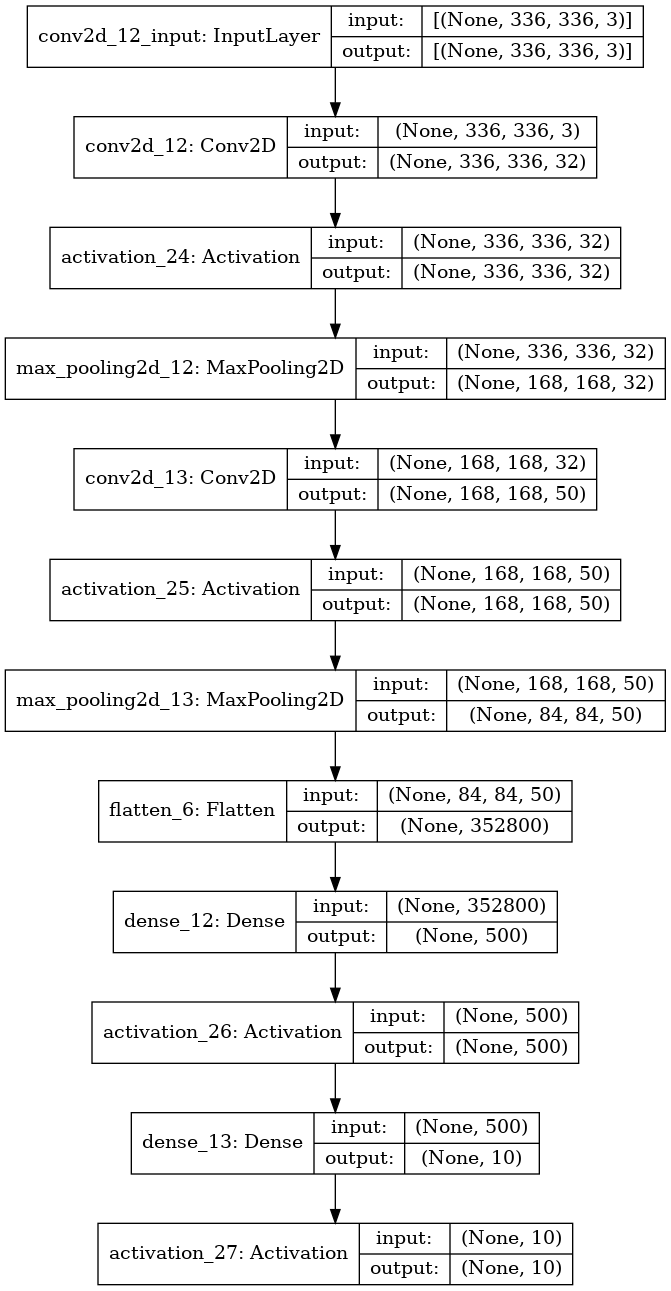

In [157]:
plot_model(model, show_shapes=True, show_layer_names=True)

__Train model__

In [158]:
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=32,
              epochs=20,
              verbose=1)

Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 2.6413 - accuracy: 0.0615 - val_loss: 2.3092 - val_accuracy: 0.1000
Epoch 2/20
4/4 [==============================] - 7s 2s/step - loss: 2.2701 - accuracy: 0.1449 - val_loss: 2.2914 - val_accuracy: 0.1000
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 2.2653 - accuracy: 0.0963 - val_loss: 2.3479 - val_accuracy: 0.1000
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 2.2566 - accuracy: 0.1392 - val_loss: 2.2829 - val_accuracy: 0.1400
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 2.1877 - accuracy: 0.2354 - val_loss: 2.2790 - val_accuracy: 0.1400
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 2.1666 - accuracy: 0.2007 - val_loss: 2.3333 - val_accuracy: 0.1200
Epoch 7/20
4/4 [==============================] - 7s 2s/step - loss: 2.1544 - accuracy: 0.2245 - val_loss: 2.2873 - val_accuracy: 0.1200
Epoch 8/20
4/4 [=========================

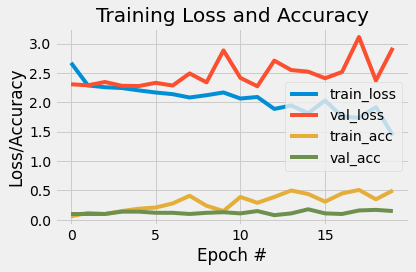

In [159]:
plot_history(H,20)

__Evaluate model__

In [160]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

              precision    recall  f1-score   support

     Cezanne       0.00      0.00      0.00        10
       Degas       0.50      0.10      0.17        10
     Gauguin       0.16      0.50      0.24        10
      Hassam       0.00      0.00      0.00        10
     Matisse       0.50      0.10      0.17        10
       Monet       0.00      0.00      0.00        10
    Pissarro       0.10      0.50      0.17        10
      Renoir       0.00      0.00      0.00        10
     Sargent       0.43      0.30      0.35        10
     VanGogh       0.00      0.00      0.00        10

    accuracy                           0.15       100
   macro avg       0.17      0.15      0.11       100
weighted avg       0.17      0.15      0.11       100



/home/cds-au617836/cds-visual-forked/cv101/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cds-au617836/cds-visual-forked/cv101/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cds-au617836/cds-visual-forked/cv101/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif